#### PI7-3: AE & VAE
This notebook contains all the implementation and evaluation of the research performed on autoencoders en variational autoencoders.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [3]:
class Encoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.z_space = z_space

        # (input)1->64, 64->128, 128->256, 256->512, 512->z_space
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),

            nn.Conv2d(512, z_space, kernel_size=3, stride=2, padding=0, bias=False)
        )
        

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [4]:
class Decoder(nn.Module):
    def __init__ (self, z_space: int):
        super().__init__()
        self.z_space = z_space

        # z_space->256, 256->128, 128->64, 64->1 
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_space, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.Tanh()
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.encode = Encoder(z_space)
        self.decode = Decoder(z_space)

    def forward(self, X: torch.Tensor):
        z = self.encode(X)
        y = self.decode(z)
        
        return z, y

In [6]:
enc = Encoder(2)
dec = Decoder(2)
x = torch.randn(16, 3, 64, 64)
dec(enc(x)).shape

torch.Size([16, 3, 64, 64])

In [7]:
transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [8]:
'''Adjustable constants'''
EPOCHS = 30
BATCH_SIZE = 256
LEARNING_RATE = 0.03
LEARNING_RATE_GAMMA = 0.9

Z_DIM = 256

NUM_WORKERS = 4

In [9]:
train_dir = 'data/cifar10/train'
test_dir = 'data/cifar10/test'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
testval_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

X_test_val, y_test_val = zip(*testval_dataset)

X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

splitval = int(0.5 * len(testval_dataset))

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [splitval, splitval])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test-Val dataset size: {len(testval_dataset)}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train dataset size: 50000
Test-Val dataset size: 10000
X_test shape: torch.Size([5000, 3, 64, 64]), y_test shape: torch.Size([5000])
X_val shape: torch.Size([5000, 3, 64, 64]), y_val shape: torch.Size([5000])


In [10]:
generator = AutoEncoder(z_space=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.MSELoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        # predict and compute loss
        _, preds = generator(images)
        loss = criterion(preds, images)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        _, preds = generator(X_val.to(DEVICE))
        loss = criterion(preds, X_val.to(DEVICE))
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    z, preds = generator(X_test.to(DEVICE))
    loss = criterion(preds, X_test.to(DEVICE))
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 0.1203359067440033, val_loss 0.05344764143228531
epoch 1, train_loss 0.050792042165994644, val_loss 0.04736527428030968
epoch 2, train_loss 0.044349364936351776, val_loss 0.036434490233659744
epoch 3, train_loss 0.031502947211265564, val_loss 0.027453532442450523
epoch 4, train_loss 0.02629908174276352, val_loss 0.024306634441018105
epoch 5, train_loss 0.023768814280629158, val_loss 0.023290447890758514
epoch 6, train_loss 0.021908745169639587, val_loss 0.020364435389637947
epoch 7, train_loss 0.019880404695868492, val_loss 0.01895757205784321
epoch 8, train_loss 0.018886392936110497, val_loss 0.01811928302049637
epoch 9, train_loss 0.018112171441316605, val_loss 0.017390431836247444
epoch 10, train_loss 0.0175270177423954, val_loss 0.016891490668058395
epoch 11, train_loss 0.016984369605779648, val_loss 0.01658760756254196
epoch 12, train_loss 0.01663769967854023, val_loss 0.016236966475844383
epoch 13, train_loss 0.016228990629315376, val_loss 0.015867432579398155

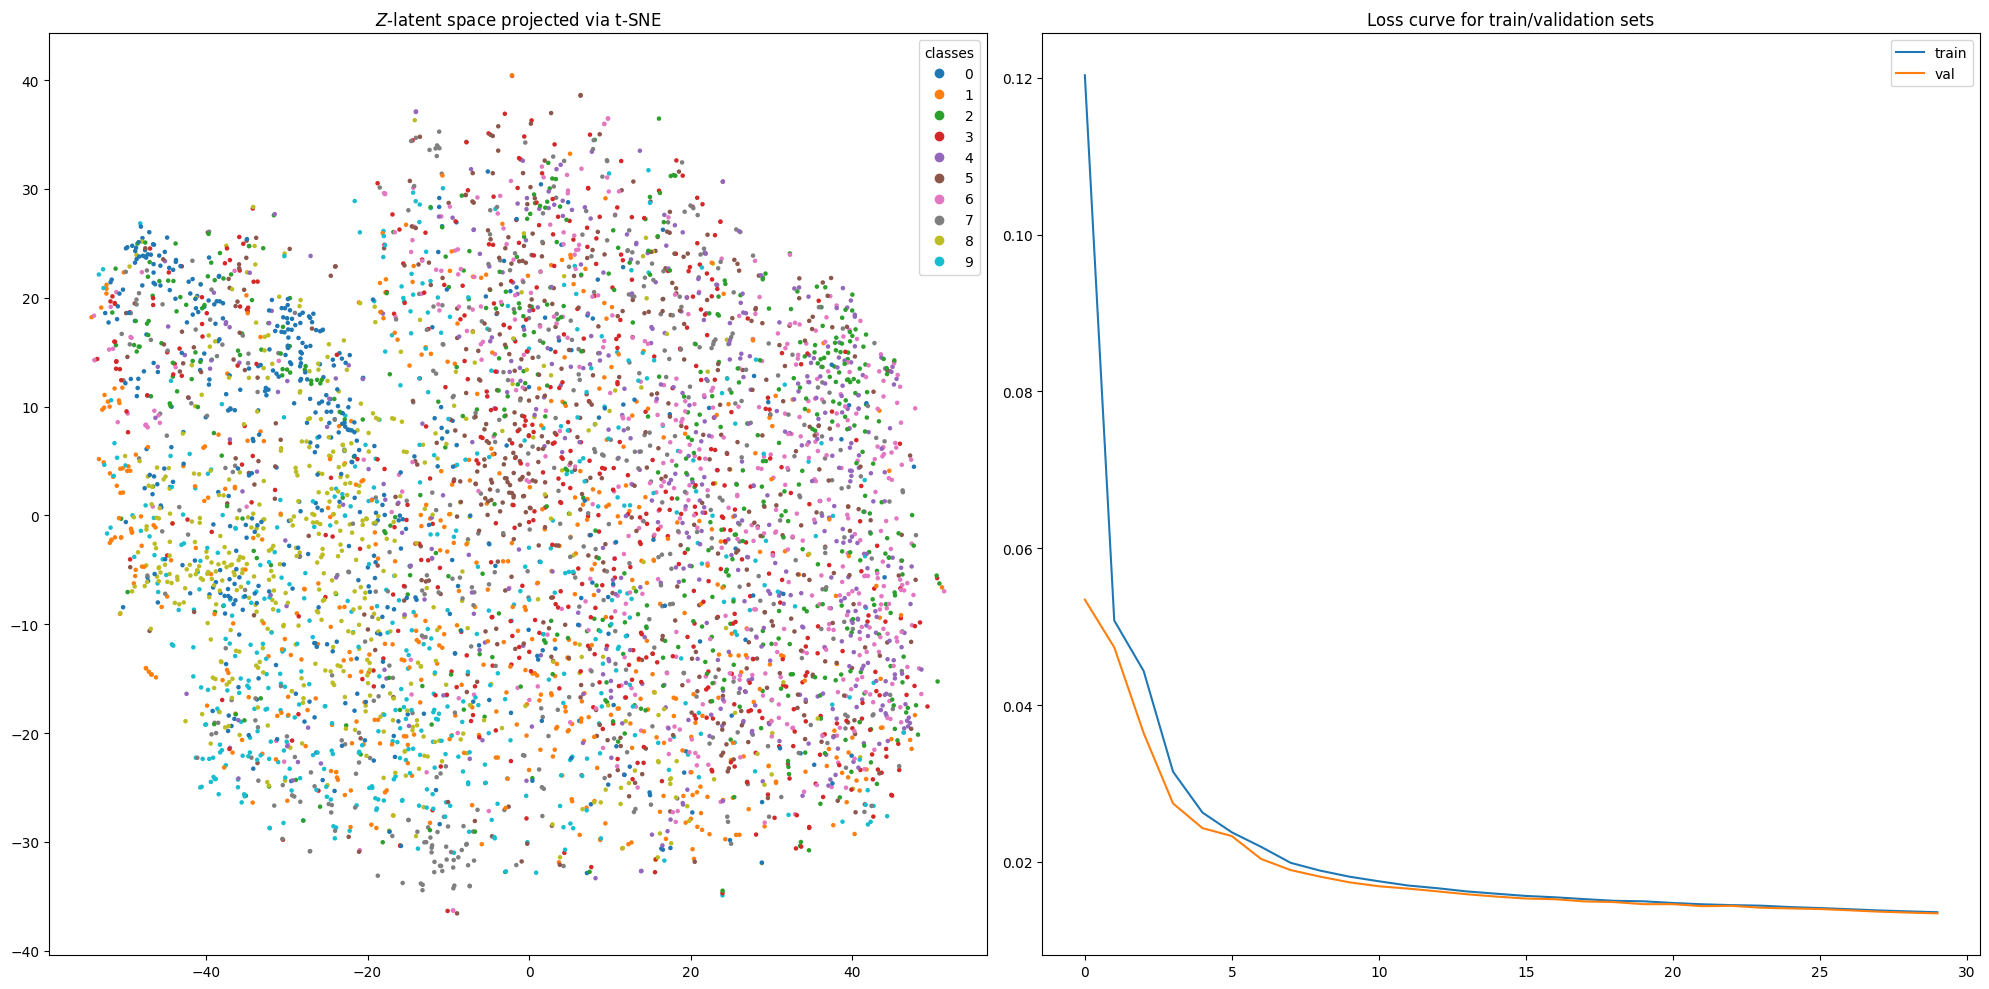

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Flatten z and move to numpy
z = z.view(z.shape[0], -1).cpu().detach().numpy()

# Apply t-SNE to reduce dimensionality
z_proj = TSNE(n_components=2, random_state=42).fit_transform(z)

# Plot t-SNE projection
sc = ax1.scatter(z_proj[:, 0], z_proj[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')
ax1.set_title("$Z$-latent space projected via t-SNE")

# Plot training and validation loss curves
ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()
ax2.set_title("Loss curve for train/validation sets")

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015904069..1.0639913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15859531..1.0156673].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15917253..1.0179669].


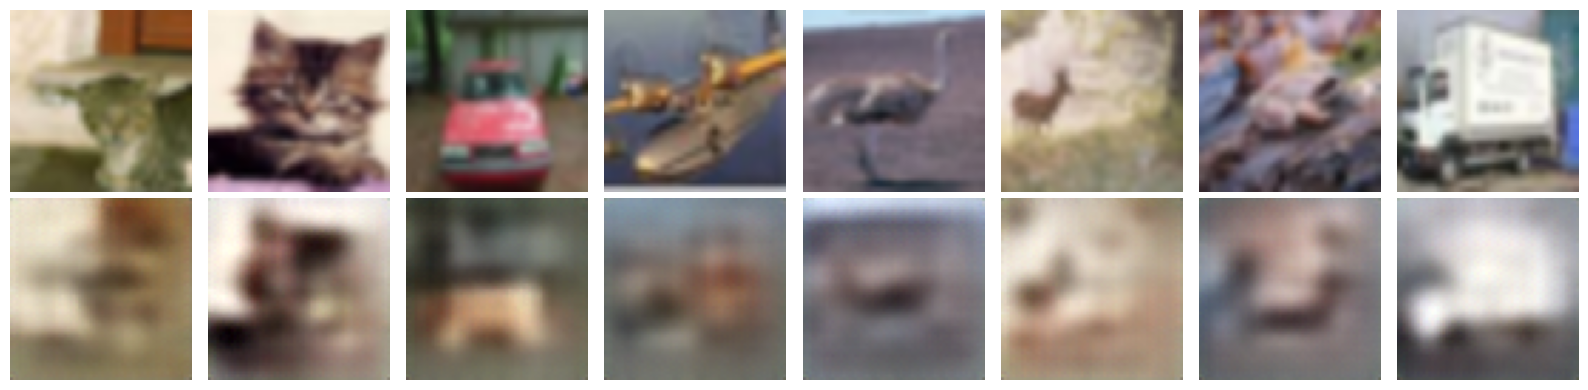

In [14]:
generator.eval()
with torch.no_grad():
    _, recon = generator(X_val[:8].to(DEVICE))

recon = recon.cpu().squeeze().numpy()
original = X_val[:8].squeeze().numpy()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
    axs[0, i].axis('off')
    axs[1, i].imshow(np.transpose(recon[i], (1, 2, 0)))
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("Reconstructed", fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
class VAE(nn.Module):
    def __init__(self, z_space: int):
        super().__init__()
        self.z_space = z_space
        self.enc = Encoder(2 * z_space)
        self.dec = Decoder(z_space)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X)
        mu = h[:, :self.z_space].view(-1, self.z_space)
        log_var = h[:, self.z_space:].view(-1, self.z_space)
        
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_space).to(mu.device)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1)
        y = self.dec(z)

        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)

        return y, z, mu, log_var

In [16]:
x = torch.randn(16, 3, 64, 64)
g = VAE(z_space=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 3, 64, 64]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

In [ ]:
EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 0.03
LEARNING_RATE_GAMMA = 0.85

# Model constants
Z_DIM = 256
LAMBDA_REC_ERR = 1
NUM_WORKERS = 4
DEVICE

device(type='cuda')

In [18]:
transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize(64),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

In [19]:
train_dir = 'data/cifar10/train'
test_dir = 'data/cifar10/test'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
testval_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

X_test_val, y_test_val = zip(*testval_dataset)

X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

splitval = int(0.5 * len(testval_dataset))

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [splitval, splitval])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test-Val dataset size: {len(testval_dataset)}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

Train dataset size: 50000
Test-Val dataset size: 10000
X_test shape: torch.Size([5000, 3, 64, 64]), y_test shape: torch.Size([5000])
X_val shape: torch.Size([5000, 3, 64, 64]), y_val shape: torch.Size([5000])


In [21]:
generator = VAE(z_space=Z_DIM).to(DEVICE)

optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=LEARNING_RATE_GAMMA)
criterion = nn.MSELoss()

train_history = []
val_history = []

for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(DEVICE)
        preds, _, mu, log_var = generator(images)
        
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = LAMBDA_REC_ERR * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))

    with torch.no_grad():
        preds, _, mu, log_var = generator(X_val.to(DEVICE))
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = LAMBDA_REC_ERR * criterion(preds, X_val.to(DEVICE))
        loss = rec_error + kl_reg
        val_history.append(loss.item())
    
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    preds, z, mu, sigma = generator(X_test.to(DEVICE))
    kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    rec_error = LAMBDA_REC_ERR * criterion(preds, X_test.to(DEVICE))
    loss = rec_error + kl_reg
    print(f"test_loss {loss.item()}")

epoch 0, train_loss 288.82244873046875, val_loss 28.406959533691406
epoch 1, train_loss 18.240692138671875, val_loss 14.933719635009766
epoch 2, train_loss 12.836275100708008, val_loss 11.785797119140625
epoch 3, train_loss 10.850290298461914, val_loss 10.302215576171875
epoch 4, train_loss 9.675832748413086, val_loss 9.341829299926758
epoch 5, train_loss 8.98671817779541, val_loss 8.993692398071289
epoch 6, train_loss 8.467585563659668, val_loss 8.418464660644531
epoch 7, train_loss 8.074085235595703, val_loss 7.981317520141602
epoch 8, train_loss 7.711016654968262, val_loss 7.691009521484375
epoch 9, train_loss 7.4930620193481445, val_loss 7.43153190612793
epoch 10, train_loss 7.298593997955322, val_loss 7.223780632019043
epoch 11, train_loss 7.168447494506836, val_loss 7.1061530113220215
epoch 12, train_loss 7.036675453186035, val_loss 6.989309310913086
epoch 13, train_loss 6.939290523529053, val_loss 6.914976119995117
epoch 14, train_loss 6.878993034362793, val_loss 6.8054733276367

In [23]:
from sklearn.decomposition import PCA
z_pca = PCA(n_components=50).fit_transform(z)
z_proj = TSNE(n_components=2).fit_transform(z_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot t-SNE projection
sc = ax1.scatter(z_proj[:, 0], z_proj[:, 1], c=y_test, s=5, cmap='tab10')
ax1.legend(*sc.legend_elements(), title='classes')
ax1.set_title("$Z$-latent space projected via t-SNE")

# Plot training and validation loss curves
ax2.plot(train_history, label="train")
ax2.plot(val_history, label="val")
ax2.legend()
ax2.set_title("Loss curve for train/validation sets")

plt.tight_layout()
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [24]:
h, w = 15, 15
z_vecs = torch.randn(h*w, Z_DIM, 1, 1).to('cuda')
 
y_preds = F.sigmoid(generator.dec(z_vecs)).squeeze().cpu().detach()
y_preds = y_preds.reshape(h, w, 64, 64).permute(1, 2, 0, 3).reshape(h*64, -1)
 
plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

RuntimeError: shape '[15, 15, 64, 64]' is invalid for input of size 2764800

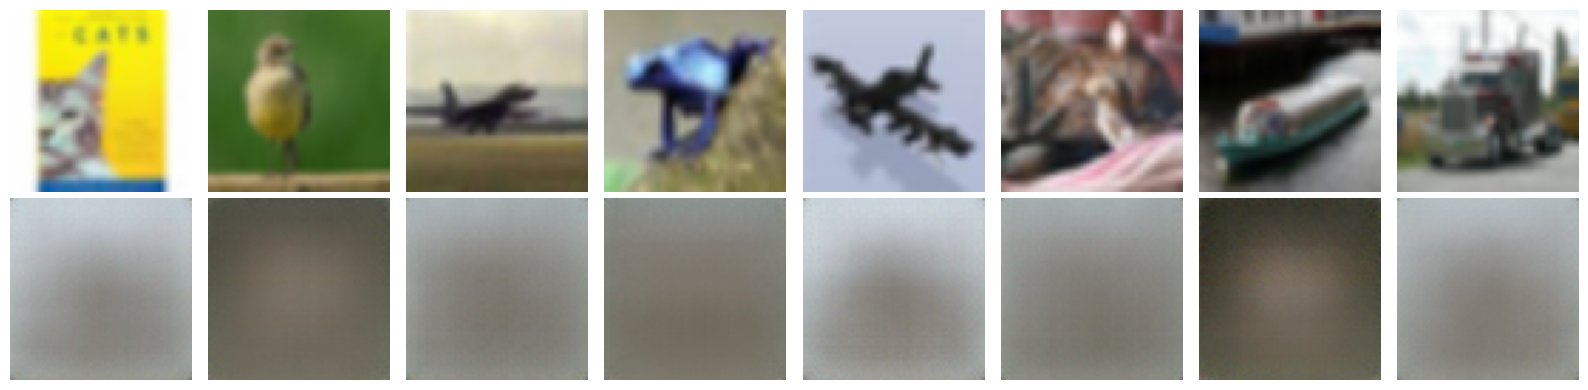

In [26]:
generator.eval()
with torch.no_grad():
    recon, _, _, _ = generator(X_val[:8].to(DEVICE))

recon = recon.cpu().squeeze().numpy()
original = X_val[:8].squeeze().numpy()

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axs[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
    axs[0, i].axis('off')
    axs[1, i].imshow(np.transpose(recon[i], (1, 2, 0)))
    axs[1, i].axis('off')
axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("Reconstructed", fontsize=12)
plt.tight_layout()
plt.show()